In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from collections import defaultdict

In [9]:
# Define constants
ACTIONS = [(0, 0), (-1, 0), (1, 0), (0, -1), (0, 1)]  # Stay, Up, Down, Left, Right
ACTION_NAMES = ['Stay', 'Up', 'Down', 'Left', 'Right']
NUM_ACTIONS = len(ACTIONS)
GAMMA = 0.9  # Discount factor
ALPHA = 0.1  # Learning rate
EPSILON = 0.25  # Exploration rate
MAX_EPISODES = 1000

# Grid environment size
GRID_SIZE = 10
grid = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)

# Walls (obstacles)
obstacles = [
    (0, 4), (1, 4), (2, 4), (2, 5), (4, 0),
    (4, 1), (4, 2), (5, 2), (9, 5), (8, 5),
    (7, 5), (7, 4), (4, 9), (4, 8), (4, 7), (5, 7)
]
for obstacle in obstacles:
    grid[obstacle] = 1

# Agent start positions and target destinations
start_positions = [(1, 1), (8, 1), (8, 8), (1, 8)]
goal_positions = [(5, 8), (1, 5), (5, 1), (8, 4)]

# Assign colors for visualization
agent_colors = ['red', 'cyan', 'orange', 'purple']

In [10]:
# Environment class for Multi-Agent Pathfinding
class MultiAgentEnvironment:
    def __init__(self, grid, agents, goals):
        self.grid = grid
        self.agents = agents
        self.goals = goals
        self.num_agents = len(agents)
        self.state = tuple(agents)
        self.steps = [0] * self.num_agents

    def is_valid_cell(self, position):
        x, y = position
        return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE and self.grid[x, y] != 1

    def reset(self):
        self.state = tuple(start_positions)
        self.steps = [0] * self.num_agents
        return self.state

    def step(self, actions):
        proposed_positions = []
        rewards = []
        collisions = set()

        for i, action in enumerate(actions):
            current_pos = self.state[i]
            move = ACTIONS[action]
            next_pos = (current_pos[0] + move[0], current_pos[1] + move[1])

            if not self.is_valid_cell(next_pos) or next_pos in self.state:
                next_pos = current_pos
            proposed_positions.append(next_pos)

        final_positions = list(self.state)
        for i, next_pos in enumerate(proposed_positions):
            if proposed_positions.count(next_pos) > 1:
                collisions.add(next_pos)
                final_positions[i] = self.state[i]
            else:
                final_positions[i] = next_pos

        new_state = tuple(final_positions)
        for i, next_pos in enumerate(new_state):
            if next_pos == self.goals[i]:
                reward = 10
            elif next_pos in collisions:
                reward = -10
            else:
                reward = -1
            rewards.append(reward)

        self.state = new_state
        done = all(new_state[i] == self.goals[i] for i in range(self.num_agents))
        for i in range(self.num_agents):
            self.steps[i] += 1

        max_steps = max(self.steps)
        return self.state, rewards, done, max_steps

In [11]:
# Training function for multi-agent Q-learning
def train_agents(env):
    q_tables = [defaultdict(lambda: np.zeros(NUM_ACTIONS)) for _ in range(env.num_agents)]
    min_max_time = float('inf')
    episode_rewards = []

    for episode in range(MAX_EPISODES):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            actions = []
            for i in range(env.num_agents):
                if np.random.rand() < EPSILON:
                    action = np.random.choice(NUM_ACTIONS)
                else:
                    action = np.argmax(q_tables[i][state[i]])
                actions.append(action)

            next_state, rewards, done, max_time = env.step(actions)

            for i in range(env.num_agents):
                current_q = q_tables[i][state[i]][actions[i]]
                next_max_q = np.max(q_tables[i][next_state[i]])
                q_tables[i][state[i]][actions[i]] = current_q + ALPHA * (
                    rewards[i] + GAMMA * next_max_q - current_q
                )

            total_reward += sum(rewards)
            state = next_state

        episode_rewards.append(total_reward)
        min_max_time = min(min_max_time, max_time)

    return q_tables, min_max_time, episode_rewards

In [12]:
# Extract optimal paths for visualization
def extract_paths(env, q_tables):
    paths = []
    for i in range(env.num_agents):
        current_pos = start_positions[i]
        path = [current_pos]

        while current_pos != goal_positions[i]:
            action = np.argmax(q_tables[i][current_pos])
            move = ACTIONS[action]
            next_pos = (current_pos[0] + move[0], current_pos[1] + move[1])

            if not env.is_valid_cell(next_pos):
                break

            path.append(next_pos)
            current_pos = next_pos

        paths.append(path)
    return paths

# Visualization of the grid and paths
def plot_grid_with_paths(grid, agents, goals, paths):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, GRID_SIZE)
    ax.set_ylim(0, GRID_SIZE)

    # Plot obstacles
    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            if grid[x, y] == 1:
                ax.add_patch(patches.Rectangle((y, GRID_SIZE - x - 1), 1, 1, color='gray'))

    # Plot agents' starting positions and goals
    for idx, (x, y) in enumerate(agents):
        ax.add_patch(patches.Rectangle((y, GRID_SIZE - x - 1), 1, 1, color=agent_colors[idx], alpha=0.6))
    for idx, (x, y) in enumerate(goals):
        ax.plot(
            y + 0.5, GRID_SIZE - x - 1 + 0.5,
            marker='*', color=agent_colors[idx], markersize=15, markeredgewidth=2
        )

    # Plot paths
    for idx, path in enumerate(paths):
        for j in range(1, len(path)):
            x1, y1 = path[j - 1]
            x2, y2 = path[j]
            ax.plot(
                [y1 + 0.5, y2 + 0.5],
                [GRID_SIZE - x1 - 1 + 0.5, GRID_SIZE - x2 - 1 + 0.5],
                color=agent_colors[idx], linewidth=2, linestyle='--'
            )

    # Add grid lines
    for i in range(GRID_SIZE + 1):
        ax.plot([0, GRID_SIZE], [i, i], color='black', linewidth=0.5)
        ax.plot([i, i], [0, GRID_SIZE], color='black', linewidth=0.5)

    ax.set_aspect('equal')
    ax.axis('off')
    plt.title("Grid World with Optimal Paths", fontsize=16)


Training completed! Minimum max time: 14
Agent 1 path: [(1, 1), (2, 1), (2, 2), (3, 2), (3, 3), (4, 3), (4, 4), (4, 5), (5, 5), (5, 6), (6, 6), (6, 7), (6, 8), (5, 8)]
Agent 2 path: [(8, 1), (8, 2), (7, 2), (7, 3), (6, 3), (5, 3), (5, 4), (5, 5), (5, 6), (4, 6), (3, 6), (2, 6), (1, 6), (1, 5)]
Agent 3 path: [(8, 8), (7, 8), (7, 7), (6, 7), (6, 6), (6, 5), (6, 4), (6, 3), (6, 2), (6, 1), (5, 1)]
Agent 4 path: [(1, 8), (2, 8), (3, 8), (3, 7), (3, 6), (3, 5), (3, 4), (3, 3), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (8, 4)]


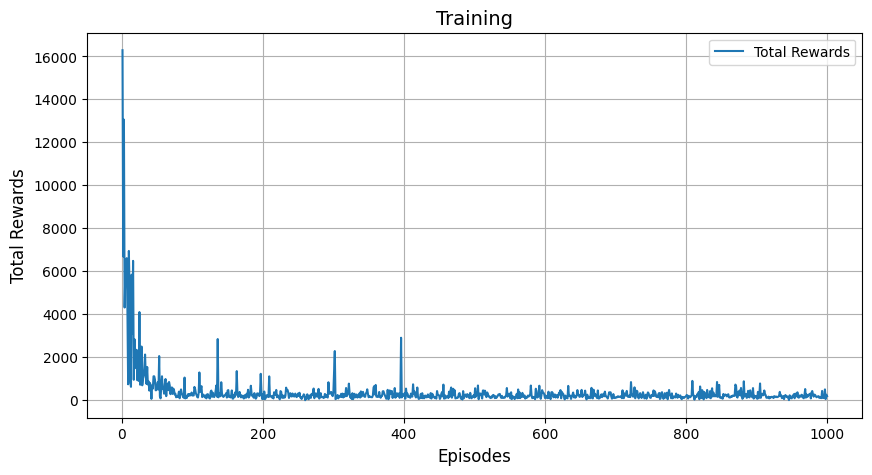

In [13]:
# Main function
if __name__ == "__main__":
    # Randomize start positions for each epoch/episode (bonus question implementation)
    random_start_positions = [
        (np.random.randint(0, grid.shape[0]), np.random.randint(0, grid.shape[1]))
        for _ in range(len(start_positions))
    ]
    
    # Ensure goal_positions are defined, or use the original goal_positions if necessary
    environment = MultiAgentEnvironment(grid, random_start_positions, goal_positions)
    
    # Train agents using the environment
    q_tables, min_max_time, rewards = train_agents(environment)
    print(f"Training completed! Minimum max time: {min_max_time}")
    
    # Extract and print the paths for each agent
    paths = extract_paths(environment, q_tables)
    for i, path in enumerate(paths):
        print(f"Agent {i + 1} path: {path}")

    # Plot training progress (total rewards over episodes)
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, MAX_EPISODES + 1), rewards, label="Total Rewards")
    plt.xlabel("Episodes", fontsize=12)
    plt.ylabel("Total Rewards", fontsize=12)
    plt.title("Training", fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.show()

